In [235]:
import os
import glob
import json
from PIL import Image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt  

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"Current Memory Usage: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print(f"Current Free Memory: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
print(torch.version.cuda)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 1.10.2
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Total Memory: 8.00 GB
Current Memory Usage: 0.06 GB
Current Free Memory: 3.40 GB
11.3
Using device: cuda


In [236]:
import torch
from torch.utils.data import Dataset
import os
import glob
from PIL import Image
import json

class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, partition=None):
        # 在 image_dir 中搜索所有 .png 文件
        self.image_paths = glob.glob(os.path.join(image_dir, '**', '*.png'), recursive=True)

        if partition:
            start, end = partition
            self.image_paths = self.image_paths[start:end]

        self.label_dir = label_dir
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)  # 数据标准化和数据增强

        relative_path = os.path.relpath(image_path, self.image_dir)
        label_path = os.path.join(self.label_dir, relative_path).replace('.png', '.json')

        labels = torch.zeros(9)

        if os.path.exists(label_path):
            with open(label_path, 'r', encoding='utf-8') as f:
                label_data = json.load(f)
                for key, value in label_data.items():
                    labels[int(key)] = float(value)

        return image, labels


In [237]:
'''
uesd to compute the mean and std :

result: Computed mean: tensor([0.0234, 0.0241, 0.0240], device='cuda:0'), std: tensor([0.0071, 0.0062, 0.0066], device='cuda:0')

from sklearn.model_selection import train_test_split

tranform = transforms.Compose([
    transforms.Resize((500,500)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.0041, 0.0044, 0.0044], std=[0.0033, 0.0028, 0.0030])
])

image_dir='./dataset/dataset/image'
label_dir='./dataset/dataset/label'
dataset = CustomDataset(image_dir, label_dir,transform=tranform)

def compute_mean_std(dataset):
    mean = torch.zeros(3).to(device)
    std = torch.zeros(3).to(device)
    for images, _ in DataLoader(dataset, batch_size=32):
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])
    mean /= len(dataset)
    std /= len(dataset)
    return mean, std


mean, std = compute_mean_std(dataset)
print(f"Computed mean: {mean}, std: {std}")

'''

'\nuesd to compute the mean and std :\n\nresult: Computed mean: tensor([0.0234, 0.0241, 0.0240], device=\'cuda:0\'), std: tensor([0.0071, 0.0062, 0.0066], device=\'cuda:0\')\n\nfrom sklearn.model_selection import train_test_split\n\ntranform = transforms.Compose([\n    transforms.Resize((500,500)),\n    transforms.ToTensor(),\n    #transforms.Normalize(mean=[0.0041, 0.0044, 0.0044], std=[0.0033, 0.0028, 0.0030])\n])\n\nimage_dir=\'./dataset/dataset/image\'\nlabel_dir=\'./dataset/dataset/label\'\ndataset = CustomDataset(image_dir, label_dir,transform=tranform)\n\ndef compute_mean_std(dataset):\n    mean = torch.zeros(3).to(device)\n    std = torch.zeros(3).to(device)\n    for images, _ in DataLoader(dataset, batch_size=32):\n        mean += images.mean(dim=[0, 2, 3])\n        std += images.std(dim=[0, 2, 3])\n    mean /= len(dataset)\n    std /= len(dataset)\n    return mean, std\n\n\nmean, std = compute_mean_std(dataset)\nprint(f"Computed mean: {mean}, std: {std}")\n\n'

In [238]:
from sklearn.model_selection import train_test_split

tranform = transforms.Compose([
    transforms.Resize((256,256)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0234, 0.0241, 0.0240], std=[0.0071, 0.0062, 0.0066])
])

validation_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0234, 0.0241, 0.0240], std=[0.0071, 0.0062, 0.0066])
])

image_dir='./dataset/dataset/image'
label_dir='./dataset/dataset/label'
dataset = CustomDataset(image_dir,label_dir,transform=tranform)
'''
train_paths, test_paths = train_test_split(dataset.image_paths,test_size=0.2,random_state=42)

train_dataset = CustomDataset(image_dir, label_dir, transform=tranform, partition=(0, len(train_paths)))
test_dataset = CustomDataset(image_dir, label_dir, transform=validation_transforms, partition=(len(train_paths), len(dataset.image_paths)))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0,pin_memory=True)
'''

'\ntrain_paths, test_paths = train_test_split(dataset.image_paths,test_size=0.2,random_state=42)\n\ntrain_dataset = CustomDataset(image_dir, label_dir, transform=tranform, partition=(0, len(train_paths)))\ntest_dataset = CustomDataset(image_dir, label_dir, transform=validation_transforms, partition=(len(train_paths), len(dataset.image_paths)))\n\ntrain_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0,pin_memory=True)\ntest_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0,pin_memory=True)\n'

In [239]:
# 首先，获取所有的标签
all_labels = []
for idx in range(len(dataset)):
    _, labels = dataset[idx]
    all_labels.append(labels.numpy())

all_labels = np.vstack(all_labels)


#test
print(all_labels[1])

# 获取正样本和负样本的索引
positive_indices = np.where(all_labels.sum(axis=1) > 0)[0]
negative_indices = np.where(all_labels.sum(axis=1) == 0)[0]

# 设置负样本与正样本的比例
negative_sample_size = len(positive_indices) // 2

# 如果负样本数量少于需要的样本数量，则使用全部负样本
if len(negative_indices) < negative_sample_size:
    negative_sample_size = len(negative_indices)

# 随机选择负样本索引
np.random.seed(42)  # 固定随机种子，保证结果可复现
selected_negative_indices = np.random.choice(negative_indices, size=negative_sample_size, replace=False)

# 合并正样本和欠采样后的负样本索引
balanced_indices = np.concatenate([positive_indices, selected_negative_indices])


[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [240]:
print(all_labels[48006])
print(len(all_labels))
print(len(balanced_indices))

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
48007
11310


In [241]:
'''
from torch.utils.data import Subset

# 创建平衡的训练集
balanced_train_dataset = Subset(dataset, balanced_indices)

from sklearn.model_selection import train_test_split

# 将平衡的数据集划分为训练集和验证集
train_indices, val_indices = train_test_split(balanced_indices, test_size=0.2, random_state=42)

# 创建训练集和验证集
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
'''


'\nfrom torch.utils.data import Subset\n\n# 创建平衡的训练集\nbalanced_train_dataset = Subset(dataset, balanced_indices)\n\nfrom sklearn.model_selection import train_test_split\n\n# 将平衡的数据集划分为训练集和验证集\ntrain_indices, val_indices = train_test_split(balanced_indices, test_size=0.2, random_state=42)\n\n# 创建训练集和验证集\ntrain_dataset = Subset(dataset, train_indices)\nval_dataset = Subset(dataset, val_indices)\n\nfrom torch.utils.data import DataLoader\n\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)\nval_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)\n'

In [ ]:
from torch.utils.data import Subset
import numpy as np
from sklearn.model_selection import train_test_split

# 假设 balanced_indices 已经定义，并且是平衡后的数据索引
# 随机选择一半的数据进行快速验证
np.random.shuffle(balanced_indices)
half_indices = balanced_indices[:int(len(balanced_indices)*0.5)]     #######################################################################

# 将选择的一半数据集划分为训练集和验证集
train_indices, val_indices = train_test_split(half_indices, test_size=0.2, random_state=42)

# 创建训练集和验证集
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)


In [243]:
print(len(train_dataset))
print(len(train_indices))

9048
9048


In [244]:

# 观察正负样本比例
label_counter = 0
all_labels = []
for _, labels in train_loader:
    all_labels.append(labels.numpy())
    label_counter += 1

print(label_counter)
all_labels = np.vstack(all_labels)
positive_ratio = all_labels.mean(axis=0)
print(f"Positive label ratios: {positive_ratio}")


283
Positive label ratios: [0.12422635 0.09825376 0.18236074 0.15904067 0.08863837 0.07736516
 0.04840849 0.17628205 0.26912025]


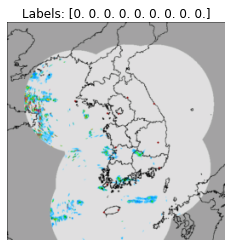

In [245]:
def view_sample(sample_index,dataset):    # 从数据集中获取一个样本
  
    image, labels = dataset[sample_index]  # 调用 __getitem__ 获取图像和标签

    # 将图像从张量转换为可显示的格式
    import matplotlib.pyplot as plt
    import numpy as np

    # 将张量转换为 NumPy 格式，并反归一化以恢复原始像素值
    def unnormalize(tensor):
        mean = np.array([0.0234, 0.0241, 0.0240])  # 和 Normalize 中的 mean 相同
        std = np.array([0.0071, 0.0062, 0.0066])   # 和 Normalize 中的 std 相同
        tensor = tensor.cpu().numpy().transpose(1, 2, 0)  # 转为 HWC 格式
        return np.clip((tensor * std) + mean, 0, 1)  # 反归一化并裁剪到 [0, 1] 范围

    # 可视化样本
    plt.imshow(unnormalize(image))
    plt.title(f"Labels: {labels.cpu().numpy()}")
    plt.axis('off')
    plt.show()

view_sample(1,dataset)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SmallResNet(nn.Module):
    def __init__(self, num_classes=9):
        super(SmallResNet, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        # Reduced number of channels
        self.layer1 = self._make_layer(ResidualBlock, 32, 64, stride=2)
        self.layer2 = self._make_layer(ResidualBlock, 64, 64, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 64, 128, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)  # Reduced input size

    def _make_layer(self, block, in_channels, out_channels, stride):
        layers = []
        layers.append(block(in_channels, out_channels, stride))
        layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# 实例化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_a = SmallResNet(num_classes=9).to(device)

# 查看参数量
total_params = sum(p.numel() for p in model_a.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")


Total parameters: 811529


In [250]:
class ModelC(nn.Module):
    def __init__(self):
        super(ModelC, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 9),
            nn.Dropout(0.5)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model_c = ModelC().to(device)

In [251]:
#处理不平衡的数据
pos_weight = (1 - positive_ratio) / positive_ratio
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)

criterion_a = nn.BCEWithLogitsLoss(pos_weight=pos_weight) #why

optimizer_a = optim.AdamW(model_a.parameters(), lr=1e-4, weight_decay=1e-2) 

scheduler_a = optim.lr_scheduler.ReduceLROnPlateau(optimizer_a, mode='max',patience=5,factor=0.5,verbose=True)


In [253]:
import numpy as np
from sklearn.metrics import f1_score

def find_best_thresholds(y_true, y_pred):
    best_thresholds = []
    for i in range(y_true.shape[1]):  # 对每个类别进行循环
        best_thresh = 0.5
        best_f1 = 0.0
        for thresh in np.arange(0.5, 0.95, 0.05):  # 遍历可能的阈值
            preds_binary = (y_pred[:, i] > thresh).astype(int)
            f1 = f1_score(y_true[:, i], preds_binary)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        best_thresholds.append(best_thresh)
    return best_thresholds


In [254]:

from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import f1_score


def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # 确保labels是张量
        if not isinstance(labels, torch.Tensor):
            labels = torch.tensor(labels, dtype=torch.float32, device=device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    preds_binary = (all_preds > 0.5).astype(int)
    epoch_f1 = f1_score(all_labels, preds_binary, average='macro')

    return epoch_loss, epoch_f1


In [255]:
from sklearn.metrics import f1_score

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    validate_loader_tqdm = tqdm(dataloader, desc="Validating", leave=False)
    with torch.no_grad():
        for inputs, labels in validate_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # 计算每个类别的最佳阈值和 F1 分数
    best_thresholds = find_best_thresholds(all_labels, all_preds)
    best_f1_scores = []

    for i in range(all_labels.shape[1]):  # 遍历每个类别
        threshold = best_thresholds[i]
        preds_binary = (all_preds[:, i] > threshold).astype(int)
        f1 = f1_score(all_labels[:, i], preds_binary)
        best_f1_scores.append(f1)

    # 打印每个类别的最佳阈值和 F1 分数
    for i in range(len(best_f1_scores)):
        print(f'Class {i}: Best Threshold: {best_thresholds[i]:.2f}, F1 Score: {best_f1_scores[i]:.4f}')

    print(f'Validation Loss: {epoch_loss:.4f}')

    # 返回整体验证损失，每类的最佳阈值，每类的 F1 分数，和所有预测
    return epoch_loss, best_thresholds, best_f1_scores, all_preds



Epoch 1/100
----------


Train Loss: 1.1184, F1 Score: 0.2916


Class 0: Best Threshold: 0.50, F1 Score: 0.3140
Class 1: Best Threshold: 0.60, F1 Score: 0.3723
Class 2: Best Threshold: 0.50, F1 Score: 0.3786
Class 3: Best Threshold: 0.50, F1 Score: 0.5213
Class 4: Best Threshold: 0.50, F1 Score: 0.4171
Class 5: Best Threshold: 0.50, F1 Score: 0.3397
Class 6: Best Threshold: 0.50, F1 Score: 0.2211
Class 7: Best Threshold: 0.50, F1 Score: 0.3333
Class 8: Best Threshold: 0.50, F1 Score: 0.5798
Validation Loss: 1.0667
current avg f1: 0.3863
Best model saved.
Epoch 2/100
----------


Train Loss: 1.0270, F1 Score: 0.3481


Class 0: Best Threshold: 0.60, F1 Score: 0.3293
Class 1: Best Threshold: 0.75, F1 Score: 0.3678
Class 2: Best Threshold: 0.80, F1 Score: 0.4398
Class 3: Best Threshold: 0.85, F1 Score: 0.5212
Class 4: Best Threshold: 0.90, F1 Score: 0.4680
Class 5: Best Threshold: 0.90, F1 Score: 0.3699
Class 6: Best Threshold: 0.85, F1 Score: 0.2552
Class 7: Best Threshold: 0.50, F1 Score: 0.3672
Class 8: Best Threshold: 0.85, F1 Score: 0.5991
Validation Loss: 1.2611
current avg f1: 0.4131
Best model saved.
Epoch 3/100
----------


Train Loss: 0.9734, F1 Score: 0.3810


Class 0: Best Threshold: 0.60, F1 Score: 0.3619
Class 1: Best Threshold: 0.50, F1 Score: 0.4467
Class 2: Best Threshold: 0.50, F1 Score: 0.4778
Class 3: Best Threshold: 0.50, F1 Score: 0.3448
Class 4: Best Threshold: 0.50, F1 Score: 0.4258
Class 5: Best Threshold: 0.50, F1 Score: 0.3264
Class 6: Best Threshold: 0.65, F1 Score: 0.3087
Class 7: Best Threshold: 0.50, F1 Score: 0.3611
Class 8: Best Threshold: 0.50, F1 Score: 0.3140
Validation Loss: 1.0747
current avg f1: 0.3741
No improvement for 1 epoch(s).
Epoch 4/100
----------


Train Loss: 0.9308, F1 Score: 0.4048


Class 0: Best Threshold: 0.60, F1 Score: 0.4594
Class 1: Best Threshold: 0.65, F1 Score: 0.4636
Class 2: Best Threshold: 0.50, F1 Score: 0.4963
Class 3: Best Threshold: 0.70, F1 Score: 0.5450
Class 4: Best Threshold: 0.70, F1 Score: 0.5381
Class 5: Best Threshold: 0.65, F1 Score: 0.4657
Class 6: Best Threshold: 0.65, F1 Score: 0.2822
Class 7: Best Threshold: 0.55, F1 Score: 0.4653
Class 8: Best Threshold: 0.60, F1 Score: 0.6251
Validation Loss: 0.9085
current avg f1: 0.4823
Best model saved.
Epoch 5/100
----------


Train Loss: 0.8969, F1 Score: 0.4254


Class 0: Best Threshold: 0.60, F1 Score: 0.4506
Class 1: Best Threshold: 0.70, F1 Score: 0.5000
Class 2: Best Threshold: 0.90, F1 Score: 0.5287
Class 3: Best Threshold: 0.85, F1 Score: 0.5269
Class 4: Best Threshold: 0.90, F1 Score: 0.3283
Class 5: Best Threshold: 0.90, F1 Score: 0.3465
Class 6: Best Threshold: 0.90, F1 Score: 0.2812
Class 7: Best Threshold: 0.50, F1 Score: 0.4659
Class 8: Best Threshold: 0.90, F1 Score: 0.5667
Validation Loss: 1.2859
current avg f1: 0.4439
No improvement for 1 epoch(s).
Epoch 6/100
----------


Train Loss: 0.8666, F1 Score: 0.4394


Class 0: Best Threshold: 0.80, F1 Score: 0.4255
Class 1: Best Threshold: 0.65, F1 Score: 0.5122
Class 2: Best Threshold: 0.50, F1 Score: 0.5665
Class 3: Best Threshold: 0.50, F1 Score: 0.5833
Class 4: Best Threshold: 0.55, F1 Score: 0.5787
Class 5: Best Threshold: 0.75, F1 Score: 0.4890
Class 6: Best Threshold: 0.90, F1 Score: 0.4093
Class 7: Best Threshold: 0.55, F1 Score: 0.4580
Class 8: Best Threshold: 0.50, F1 Score: 0.6245
Validation Loss: 0.8487
current avg f1: 0.5163
Best model saved.
Epoch 7/100
----------


Train Loss: 0.8435, F1 Score: 0.4536


Class 0: Best Threshold: 0.50, F1 Score: 0.4121
Class 1: Best Threshold: 0.75, F1 Score: 0.5045
Class 2: Best Threshold: 0.70, F1 Score: 0.5775
Class 3: Best Threshold: 0.70, F1 Score: 0.5756
Class 4: Best Threshold: 0.70, F1 Score: 0.6080
Class 5: Best Threshold: 0.60, F1 Score: 0.5289
Class 6: Best Threshold: 0.65, F1 Score: 0.4747
Class 7: Best Threshold: 0.50, F1 Score: 0.4882
Class 8: Best Threshold: 0.65, F1 Score: 0.6671
Validation Loss: 0.8376
current avg f1: 0.5374
Best model saved.
Epoch 8/100
----------


Train Loss: 0.8087, F1 Score: 0.4706


Class 0: Best Threshold: 0.70, F1 Score: 0.5009
Class 1: Best Threshold: 0.55, F1 Score: 0.5137
Class 2: Best Threshold: 0.50, F1 Score: 0.4796
Class 3: Best Threshold: 0.50, F1 Score: 0.5747
Class 4: Best Threshold: 0.50, F1 Score: 0.5639
Class 5: Best Threshold: 0.50, F1 Score: 0.5100
Class 6: Best Threshold: 0.50, F1 Score: 0.3716
Class 7: Best Threshold: 0.50, F1 Score: 0.4607
Class 8: Best Threshold: 0.50, F1 Score: 0.6374
Validation Loss: 0.9050
current avg f1: 0.5125
No improvement for 1 epoch(s).
Epoch 9/100
----------


Train Loss: 0.7892, F1 Score: 0.4807


Class 0: Best Threshold: 0.80, F1 Score: 0.4591
Class 1: Best Threshold: 0.80, F1 Score: 0.4858
Class 2: Best Threshold: 0.85, F1 Score: 0.5169
Class 3: Best Threshold: 0.90, F1 Score: 0.5453
Class 4: Best Threshold: 0.90, F1 Score: 0.4281
Class 5: Best Threshold: 0.90, F1 Score: 0.3968
Class 6: Best Threshold: 0.90, F1 Score: 0.3128
Class 7: Best Threshold: 0.55, F1 Score: 0.5005
Class 8: Best Threshold: 0.75, F1 Score: 0.6485
Validation Loss: 1.0709
current avg f1: 0.4771
No improvement for 2 epoch(s).
Epoch 10/100
----------


Train Loss: 0.7525, F1 Score: 0.5012


Class 0: Best Threshold: 0.80, F1 Score: 0.4708
Class 1: Best Threshold: 0.80, F1 Score: 0.5508
Class 2: Best Threshold: 0.50, F1 Score: 0.5017
Class 3: Best Threshold: 0.60, F1 Score: 0.5745
Class 4: Best Threshold: 0.70, F1 Score: 0.5554
Class 5: Best Threshold: 0.90, F1 Score: 0.4792
Class 6: Best Threshold: 0.90, F1 Score: 0.4237
Class 7: Best Threshold: 0.50, F1 Score: 0.4474
Class 8: Best Threshold: 0.50, F1 Score: 0.6582
Validation Loss: 0.8128
current avg f1: 0.5180
No improvement for 3 epoch(s).
Epoch 11/100
----------


Train Loss: 0.7252, F1 Score: 0.5183


Class 0: Best Threshold: 0.50, F1 Score: 0.3909
Class 1: Best Threshold: 0.90, F1 Score: 0.5509
Class 2: Best Threshold: 0.50, F1 Score: 0.6283
Class 3: Best Threshold: 0.75, F1 Score: 0.5512
Class 4: Best Threshold: 0.50, F1 Score: 0.5813
Class 5: Best Threshold: 0.50, F1 Score: 0.4534
Class 6: Best Threshold: 0.55, F1 Score: 0.4195
Class 7: Best Threshold: 0.50, F1 Score: 0.4904
Class 8: Best Threshold: 0.70, F1 Score: 0.6571
Validation Loss: 0.9906
current avg f1: 0.5248
No improvement for 4 epoch(s).
Epoch 12/100
----------


Train Loss: 0.6979, F1 Score: 0.5344


Class 0: Best Threshold: 0.65, F1 Score: 0.4841
Class 1: Best Threshold: 0.75, F1 Score: 0.5547
Class 2: Best Threshold: 0.60, F1 Score: 0.5891
Class 3: Best Threshold: 0.70, F1 Score: 0.5438
Class 4: Best Threshold: 0.80, F1 Score: 0.6000
Class 5: Best Threshold: 0.85, F1 Score: 0.5579
Class 6: Best Threshold: 0.85, F1 Score: 0.4355
Class 7: Best Threshold: 0.65, F1 Score: 0.5053
Class 8: Best Threshold: 0.60, F1 Score: 0.6568
Validation Loss: 0.8377
current avg f1: 0.5475
Best model saved.
Epoch 13/100
----------


Train Loss: 0.6744, F1 Score: 0.5470


Class 0: Best Threshold: 0.85, F1 Score: 0.5037
Class 1: Best Threshold: 0.70, F1 Score: 0.5721
Class 2: Best Threshold: 0.55, F1 Score: 0.5802
Class 3: Best Threshold: 0.60, F1 Score: 0.5703
Class 4: Best Threshold: 0.70, F1 Score: 0.5904
Class 5: Best Threshold: 0.85, F1 Score: 0.5318
Class 6: Best Threshold: 0.80, F1 Score: 0.3871
Class 7: Best Threshold: 0.70, F1 Score: 0.5311
Class 8: Best Threshold: 0.50, F1 Score: 0.6492
Validation Loss: 0.7945
current avg f1: 0.5462
No improvement for 1 epoch(s).
Epoch 14/100
----------


Train Loss: 0.6447, F1 Score: 0.5634


Class 0: Best Threshold: 0.55, F1 Score: 0.4761
Class 1: Best Threshold: 0.85, F1 Score: 0.6000
Class 2: Best Threshold: 0.50, F1 Score: 0.5962
Class 3: Best Threshold: 0.75, F1 Score: 0.5650
Class 4: Best Threshold: 0.80, F1 Score: 0.6206
Class 5: Best Threshold: 0.80, F1 Score: 0.5374
Class 6: Best Threshold: 0.90, F1 Score: 0.4525
Class 7: Best Threshold: 0.55, F1 Score: 0.5343
Class 8: Best Threshold: 0.65, F1 Score: 0.6662
Validation Loss: 0.7588
current avg f1: 0.5609
Best model saved.
Epoch 15/100
----------


Train Loss: 0.6230, F1 Score: 0.5743


Class 0: Best Threshold: 0.85, F1 Score: 0.4846
Class 1: Best Threshold: 0.60, F1 Score: 0.5625
Class 2: Best Threshold: 0.85, F1 Score: 0.5620
Class 3: Best Threshold: 0.50, F1 Score: 0.5831
Class 4: Best Threshold: 0.90, F1 Score: 0.5974
Class 5: Best Threshold: 0.90, F1 Score: 0.4965
Class 6: Best Threshold: 0.90, F1 Score: 0.3396
Class 7: Best Threshold: 0.85, F1 Score: 0.4977
Class 8: Best Threshold: 0.50, F1 Score: 0.6279
Validation Loss: 0.9103
current avg f1: 0.5279
No improvement for 1 epoch(s).
Epoch 16/100
----------


Train Loss: 0.6025, F1 Score: 0.5874


Class 0: Best Threshold: 0.50, F1 Score: 0.4934
Class 1: Best Threshold: 0.75, F1 Score: 0.5345
Class 2: Best Threshold: 0.50, F1 Score: 0.6113
Class 3: Best Threshold: 0.85, F1 Score: 0.5642
Class 4: Best Threshold: 0.75, F1 Score: 0.6026
Class 5: Best Threshold: 0.85, F1 Score: 0.5201
Class 6: Best Threshold: 0.55, F1 Score: 0.4046
Class 7: Best Threshold: 0.50, F1 Score: 0.4114
Class 8: Best Threshold: 0.75, F1 Score: 0.6573
Validation Loss: 0.8293
current avg f1: 0.5333
No improvement for 2 epoch(s).
Epoch 17/100
----------


Train Loss: 0.5832, F1 Score: 0.6003


Class 0: Best Threshold: 0.55, F1 Score: 0.5193
Class 1: Best Threshold: 0.55, F1 Score: 0.5802
Class 2: Best Threshold: 0.75, F1 Score: 0.6209
Class 3: Best Threshold: 0.50, F1 Score: 0.5722
Class 4: Best Threshold: 0.50, F1 Score: 0.5720
Class 5: Best Threshold: 0.50, F1 Score: 0.5146
Class 6: Best Threshold: 0.50, F1 Score: 0.4000
Class 7: Best Threshold: 0.60, F1 Score: 0.5592
Class 8: Best Threshold: 0.50, F1 Score: 0.6569
Validation Loss: 0.9001
current avg f1: 0.5550
No improvement for 3 epoch(s).
Epoch 18/100
----------


Train Loss: 0.5673, F1 Score: 0.6072


Class 0: Best Threshold: 0.70, F1 Score: 0.5008
Class 1: Best Threshold: 0.70, F1 Score: 0.5820
Class 2: Best Threshold: 0.55, F1 Score: 0.6379
Class 3: Best Threshold: 0.50, F1 Score: 0.5738
Class 4: Best Threshold: 0.65, F1 Score: 0.5950
Class 5: Best Threshold: 0.65, F1 Score: 0.5370
Class 6: Best Threshold: 0.50, F1 Score: 0.4560
Class 7: Best Threshold: 0.65, F1 Score: 0.5486
Class 8: Best Threshold: 0.50, F1 Score: 0.6558
Validation Loss: 0.8038
current avg f1: 0.5652
Best model saved.
Epoch 19/100
----------


Train Loss: 0.5435, F1 Score: 0.6216


Class 0: Best Threshold: 0.65, F1 Score: 0.4884
Class 1: Best Threshold: 0.75, F1 Score: 0.5495
Class 2: Best Threshold: 0.75, F1 Score: 0.5625
Class 3: Best Threshold: 0.90, F1 Score: 0.5239
Class 4: Best Threshold: 0.90, F1 Score: 0.4582
Class 5: Best Threshold: 0.90, F1 Score: 0.4569
Class 6: Best Threshold: 0.90, F1 Score: 0.3940
Class 7: Best Threshold: 0.50, F1 Score: 0.4356
Class 8: Best Threshold: 0.90, F1 Score: 0.6138
Validation Loss: 1.0863
current avg f1: 0.4981
No improvement for 1 epoch(s).
Epoch 20/100
----------


Train Loss: 0.5350, F1 Score: 0.6212


Class 0: Best Threshold: 0.50, F1 Score: 0.4370
Class 1: Best Threshold: 0.90, F1 Score: 0.3974
Class 2: Best Threshold: 0.50, F1 Score: 0.3964
Class 3: Best Threshold: 0.80, F1 Score: 0.5140
Class 4: Best Threshold: 0.50, F1 Score: 0.5160
Class 5: Best Threshold: 0.50, F1 Score: 0.4847
Class 6: Best Threshold: 0.55, F1 Score: 0.4021
Class 7: Best Threshold: 0.65, F1 Score: 0.5164
Class 8: Best Threshold: 0.85, F1 Score: 0.5705
Validation Loss: 1.1725
current avg f1: 0.4705
No improvement for 2 epoch(s).
Epoch 21/100
----------


Train Loss: 0.5214, F1 Score: 0.6299


Class 0: Best Threshold: 0.90, F1 Score: 0.4459
Class 1: Best Threshold: 0.90, F1 Score: 0.4713
Class 2: Best Threshold: 0.50, F1 Score: 0.4771
Class 3: Best Threshold: 0.90, F1 Score: 0.5023
Class 4: Best Threshold: 0.90, F1 Score: 0.3757
Class 5: Best Threshold: 0.90, F1 Score: 0.3169
Class 6: Best Threshold: 0.90, F1 Score: 0.2463
Class 7: Best Threshold: 0.65, F1 Score: 0.5196
Class 8: Best Threshold: 0.80, F1 Score: 0.6244
Validation Loss: 1.4418
current avg f1: 0.4422
No improvement for 3 epoch(s).
Epoch 22/100
----------


Train Loss: 0.5104, F1 Score: 0.6380


Class 0: Best Threshold: 0.55, F1 Score: 0.5134
Class 1: Best Threshold: 0.65, F1 Score: 0.5955
Class 2: Best Threshold: 0.55, F1 Score: 0.6279
Class 3: Best Threshold: 0.60, F1 Score: 0.5869
Class 4: Best Threshold: 0.60, F1 Score: 0.5842
Class 5: Best Threshold: 0.60, F1 Score: 0.5089
Class 6: Best Threshold: 0.50, F1 Score: 0.4502
Class 7: Best Threshold: 0.50, F1 Score: 0.5078
Class 8: Best Threshold: 0.65, F1 Score: 0.6774
Validation Loss: 0.8457
current avg f1: 0.5613
No improvement for 4 epoch(s).
Epoch 23/100
----------


Train Loss: 0.4974, F1 Score: 0.6462


Class 0: Best Threshold: 0.90, F1 Score: 0.5209
Class 1: Best Threshold: 0.50, F1 Score: 0.5747
Class 2: Best Threshold: 0.50, F1 Score: 0.6234
Class 3: Best Threshold: 0.60, F1 Score: 0.5979
Class 4: Best Threshold: 0.80, F1 Score: 0.5811
Class 5: Best Threshold: 0.90, F1 Score: 0.5141
Class 6: Best Threshold: 0.90, F1 Score: 0.4322
Class 7: Best Threshold: 0.60, F1 Score: 0.5832
Class 8: Best Threshold: 0.55, F1 Score: 0.6777
Validation Loss: 0.7913
current avg f1: 0.5673
Best model saved.
Epoch 24/100
----------


Train Loss: 0.4843, F1 Score: 0.6548


Class 0: Best Threshold: 0.50, F1 Score: 0.5153
Class 1: Best Threshold: 0.65, F1 Score: 0.5830
Class 2: Best Threshold: 0.50, F1 Score: 0.6480
Class 3: Best Threshold: 0.60, F1 Score: 0.5919
Class 4: Best Threshold: 0.50, F1 Score: 0.5558
Class 5: Best Threshold: 0.50, F1 Score: 0.4653
Class 6: Best Threshold: 0.55, F1 Score: 0.4396
Class 7: Best Threshold: 0.60, F1 Score: 0.5727
Class 8: Best Threshold: 0.55, F1 Score: 0.6667
Validation Loss: 0.9724
current avg f1: 0.5598
No improvement for 1 epoch(s).
Epoch 25/100
----------


Train Loss: 0.4720, F1 Score: 0.6601


Class 0: Best Threshold: 0.50, F1 Score: 0.5368
Class 1: Best Threshold: 0.55, F1 Score: 0.5455
Class 2: Best Threshold: 0.50, F1 Score: 0.6217
Class 3: Best Threshold: 0.50, F1 Score: 0.6034
Class 4: Best Threshold: 0.50, F1 Score: 0.4754
Class 5: Best Threshold: 0.50, F1 Score: 0.3319
Class 6: Best Threshold: 0.50, F1 Score: 0.3077
Class 7: Best Threshold: 0.50, F1 Score: 0.5071
Class 8: Best Threshold: 0.50, F1 Score: 0.6619
Validation Loss: 1.1453
current avg f1: 0.5102
No improvement for 2 epoch(s).
Epoch 26/100
----------


Train Loss: 0.4681, F1 Score: 0.6643


Class 0: Best Threshold: 0.85, F1 Score: 0.5310
Class 1: Best Threshold: 0.50, F1 Score: 0.5281
Class 2: Best Threshold: 0.50, F1 Score: 0.6399
Class 3: Best Threshold: 0.65, F1 Score: 0.5905
Class 4: Best Threshold: 0.70, F1 Score: 0.5966
Class 5: Best Threshold: 0.60, F1 Score: 0.5157
Class 6: Best Threshold: 0.70, F1 Score: 0.4128
Class 7: Best Threshold: 0.50, F1 Score: 0.4384
Class 8: Best Threshold: 0.55, F1 Score: 0.6521
Validation Loss: 0.9321
current avg f1: 0.5450
No improvement for 3 epoch(s).
Epoch 27/100
----------


Train Loss: 0.4536, F1 Score: 0.6738


Class 0: Best Threshold: 0.60, F1 Score: 0.5471
Class 1: Best Threshold: 0.70, F1 Score: 0.5811
Class 2: Best Threshold: 0.70, F1 Score: 0.6512
Class 3: Best Threshold: 0.60, F1 Score: 0.6046
Class 4: Best Threshold: 0.55, F1 Score: 0.5898
Class 5: Best Threshold: 0.50, F1 Score: 0.5140
Class 6: Best Threshold: 0.65, F1 Score: 0.4352
Class 7: Best Threshold: 0.55, F1 Score: 0.5832
Class 8: Best Threshold: 0.60, F1 Score: 0.6667
Validation Loss: 0.8289
current avg f1: 0.5748
Best model saved.
Epoch 28/100
----------


Train Loss: 0.4421, F1 Score: 0.6787


Class 0: Best Threshold: 0.50, F1 Score: 0.5160
Class 1: Best Threshold: 0.85, F1 Score: 0.5497
Class 2: Best Threshold: 0.80, F1 Score: 0.6353
Class 3: Best Threshold: 0.60, F1 Score: 0.5944
Class 4: Best Threshold: 0.70, F1 Score: 0.5772
Class 5: Best Threshold: 0.75, F1 Score: 0.5123
Class 6: Best Threshold: 0.80, F1 Score: 0.4523
Class 7: Best Threshold: 0.55, F1 Score: 0.5846
Class 8: Best Threshold: 0.55, F1 Score: 0.6845
Validation Loss: 0.8182
current avg f1: 0.5674
No improvement for 1 epoch(s).
Epoch 29/100
----------


Train Loss: 0.4292, F1 Score: 0.6889


Class 0: Best Threshold: 0.55, F1 Score: 0.5020
Class 1: Best Threshold: 0.85, F1 Score: 0.5826
Class 2: Best Threshold: 0.85, F1 Score: 0.6187
Class 3: Best Threshold: 0.80, F1 Score: 0.5993
Class 4: Best Threshold: 0.90, F1 Score: 0.5919
Class 5: Best Threshold: 0.90, F1 Score: 0.5314
Class 6: Best Threshold: 0.90, F1 Score: 0.4211
Class 7: Best Threshold: 0.50, F1 Score: 0.5605
Class 8: Best Threshold: 0.65, F1 Score: 0.6843
Validation Loss: 0.8029
current avg f1: 0.5658
No improvement for 2 epoch(s).
Epoch 30/100
----------


Train Loss: 0.4217, F1 Score: 0.6910


Class 0: Best Threshold: 0.50, F1 Score: 0.5032
Class 1: Best Threshold: 0.50, F1 Score: 0.4295
Class 2: Best Threshold: 0.70, F1 Score: 0.6465
Class 3: Best Threshold: 0.50, F1 Score: 0.4772
Class 4: Best Threshold: 0.50, F1 Score: 0.3481
Class 5: Best Threshold: 0.50, F1 Score: 0.3133
Class 6: Best Threshold: 0.50, F1 Score: 0.3735
Class 7: Best Threshold: 0.50, F1 Score: 0.5364
Class 8: Best Threshold: 0.50, F1 Score: 0.5855
Validation Loss: 1.5521
current avg f1: 0.4681
No improvement for 3 epoch(s).
Epoch 31/100
----------


Train Loss: 0.4161, F1 Score: 0.6952


Class 0: Best Threshold: 0.50, F1 Score: 0.4537
Class 1: Best Threshold: 0.65, F1 Score: 0.5809
Class 2: Best Threshold: 0.50, F1 Score: 0.6029
Class 3: Best Threshold: 0.90, F1 Score: 0.5659
Class 4: Best Threshold: 0.70, F1 Score: 0.5908
Class 5: Best Threshold: 0.50, F1 Score: 0.4954
Class 6: Best Threshold: 0.50, F1 Score: 0.3659
Class 7: Best Threshold: 0.50, F1 Score: 0.2845
Class 8: Best Threshold: 0.85, F1 Score: 0.6980
Validation Loss: 1.1922
current avg f1: 0.5153
No improvement for 4 epoch(s).
Epoch 32/100
----------


Train Loss: 0.4031, F1 Score: 0.7021


Class 0: Best Threshold: 0.50, F1 Score: 0.4146
Class 1: Best Threshold: 0.90, F1 Score: 0.5902
Class 2: Best Threshold: 0.75, F1 Score: 0.6441
Class 3: Best Threshold: 0.90, F1 Score: 0.5811
Class 4: Best Threshold: 0.90, F1 Score: 0.5857
Class 5: Best Threshold: 0.85, F1 Score: 0.5232
Class 6: Best Threshold: 0.65, F1 Score: 0.4417
Class 7: Best Threshold: 0.50, F1 Score: 0.4838
Class 8: Best Threshold: 0.90, F1 Score: 0.6947
Validation Loss: 0.9504
current avg f1: 0.5510
No improvement for 5 epoch(s).
Epoch 33/100
----------


Train Loss: 0.3955, F1 Score: 0.7084


Class 0: Best Threshold: 0.50, F1 Score: 0.4777
Class 1: Best Threshold: 0.90, F1 Score: 0.5405
Class 2: Best Threshold: 0.50, F1 Score: 0.6379
Class 3: Best Threshold: 0.80, F1 Score: 0.5885
Class 4: Best Threshold: 0.70, F1 Score: 0.5900
Class 5: Best Threshold: 0.80, F1 Score: 0.5562
Class 6: Best Threshold: 0.80, F1 Score: 0.4112
Class 7: Best Threshold: 0.50, F1 Score: 0.5636
Class 8: Best Threshold: 0.65, F1 Score: 0.6938
Validation Loss: 0.8512
Epoch    33: reducing learning rate of group 0 to 5.0000e-05.
current avg f1: 0.5622
No improvement for 6 epoch(s).
Epoch 34/100
----------


Train Loss: 0.3633, F1 Score: 0.7293


Class 0: Best Threshold: 0.55, F1 Score: 0.5000
Class 1: Best Threshold: 0.85, F1 Score: 0.5786
Class 2: Best Threshold: 0.55, F1 Score: 0.6551
Class 3: Best Threshold: 0.60, F1 Score: 0.5968
Class 4: Best Threshold: 0.55, F1 Score: 0.5450
Class 5: Best Threshold: 0.65, F1 Score: 0.5000
Class 6: Best Threshold: 0.55, F1 Score: 0.3878
Class 7: Best Threshold: 0.60, F1 Score: 0.5802
Class 8: Best Threshold: 0.70, F1 Score: 0.6949
Validation Loss: 0.9504
current avg f1: 0.5598
No improvement for 7 epoch(s).
Epoch 35/100
----------


Train Loss: 0.3529, F1 Score: 0.7359


Class 0: Best Threshold: 0.50, F1 Score: 0.5178
Class 1: Best Threshold: 0.55, F1 Score: 0.5528
Class 2: Best Threshold: 0.50, F1 Score: 0.6119
Class 3: Best Threshold: 0.70, F1 Score: 0.5998
Class 4: Best Threshold: 0.50, F1 Score: 0.5874
Class 5: Best Threshold: 0.50, F1 Score: 0.5080
Class 6: Best Threshold: 0.50, F1 Score: 0.3600
Class 7: Best Threshold: 0.50, F1 Score: 0.3417
Class 8: Best Threshold: 0.55, F1 Score: 0.6931
Validation Loss: 1.1894
current avg f1: 0.5303
No improvement for 8 epoch(s).
Epoch 36/100
----------


Train Loss: 0.3448, F1 Score: 0.7402


Class 0: Best Threshold: 0.70, F1 Score: 0.5227
Class 1: Best Threshold: 0.85, F1 Score: 0.5639
Class 2: Best Threshold: 0.50, F1 Score: 0.6572
Class 3: Best Threshold: 0.50, F1 Score: 0.6061
Class 4: Best Threshold: 0.50, F1 Score: 0.5408
Class 5: Best Threshold: 0.55, F1 Score: 0.4783
Class 6: Best Threshold: 0.55, F1 Score: 0.4261
Class 7: Best Threshold: 0.80, F1 Score: 0.5950
Class 8: Best Threshold: 0.60, F1 Score: 0.6964
Validation Loss: 0.9800
current avg f1: 0.5652
No improvement for 9 epoch(s).
Epoch 37/100
----------


Train Loss: 0.3441, F1 Score: 0.7423


Class 0: Best Threshold: 0.50, F1 Score: 0.4232
Class 1: Best Threshold: 0.55, F1 Score: 0.5235
Class 2: Best Threshold: 0.85, F1 Score: 0.6389
Class 3: Best Threshold: 0.65, F1 Score: 0.5963
Class 4: Best Threshold: 0.55, F1 Score: 0.5798
Class 5: Best Threshold: 0.50, F1 Score: 0.4811
Class 6: Best Threshold: 0.55, F1 Score: 0.3553
Class 7: Best Threshold: 0.50, F1 Score: 0.5185
Class 8: Best Threshold: 0.50, F1 Score: 0.7022
Validation Loss: 1.3350
current avg f1: 0.5354
No improvement for 10 epoch(s).
Epoch 38/100
----------


Train Loss: 0.3315, F1 Score: 0.7490


Class 0: Best Threshold: 0.55, F1 Score: 0.5087
Class 1: Best Threshold: 0.60, F1 Score: 0.5621
Class 2: Best Threshold: 0.75, F1 Score: 0.6418
Class 3: Best Threshold: 0.50, F1 Score: 0.5779
Class 4: Best Threshold: 0.50, F1 Score: 0.5988
Class 5: Best Threshold: 0.60, F1 Score: 0.5212
Class 6: Best Threshold: 0.50, F1 Score: 0.4161
Class 7: Best Threshold: 0.80, F1 Score: 0.5813
Class 8: Best Threshold: 0.60, F1 Score: 0.7015
Validation Loss: 0.9355
current avg f1: 0.5677
No improvement for 11 epoch(s).
Epoch 39/100
----------


Train Loss: 0.3273, F1 Score: 0.7551


Class 0: Best Threshold: 0.55, F1 Score: 0.4919
Class 1: Best Threshold: 0.60, F1 Score: 0.5659
Class 2: Best Threshold: 0.85, F1 Score: 0.6356
Class 3: Best Threshold: 0.50, F1 Score: 0.5478
Class 4: Best Threshold: 0.50, F1 Score: 0.5791
Class 5: Best Threshold: 0.55, F1 Score: 0.5184
Class 6: Best Threshold: 0.90, F1 Score: 0.4221
Class 7: Best Threshold: 0.85, F1 Score: 0.5789
Class 8: Best Threshold: 0.50, F1 Score: 0.6505
Validation Loss: 0.9933
Epoch    39: reducing learning rate of group 0 to 2.5000e-05.
current avg f1: 0.5545
No improvement for 12 epoch(s).
Epoch 40/100
----------


Train Loss: 0.3159, F1 Score: 0.7608


Class 0: Best Threshold: 0.80, F1 Score: 0.5228
Class 1: Best Threshold: 0.50, F1 Score: 0.5585
Class 2: Best Threshold: 0.65, F1 Score: 0.6768
Class 3: Best Threshold: 0.50, F1 Score: 0.6061
Class 4: Best Threshold: 0.50, F1 Score: 0.5649
Class 5: Best Threshold: 0.50, F1 Score: 0.5123
Class 6: Best Threshold: 0.55, F1 Score: 0.3981
Class 7: Best Threshold: 0.60, F1 Score: 0.6021
Class 8: Best Threshold: 0.50, F1 Score: 0.6811
Validation Loss: 1.0560
current avg f1: 0.5692
No improvement for 13 epoch(s).
Epoch 41/100
----------


Train Loss: 0.3087, F1 Score: 0.7654


Class 0: Best Threshold: 0.75, F1 Score: 0.5211
Class 1: Best Threshold: 0.55, F1 Score: 0.5653
Class 2: Best Threshold: 0.50, F1 Score: 0.6581
Class 3: Best Threshold: 0.55, F1 Score: 0.6119
Class 4: Best Threshold: 0.50, F1 Score: 0.5632
Class 5: Best Threshold: 0.50, F1 Score: 0.5181
Class 6: Best Threshold: 0.50, F1 Score: 0.3981
Class 7: Best Threshold: 0.55, F1 Score: 0.5947
Class 8: Best Threshold: 0.60, F1 Score: 0.6968
Validation Loss: 1.0321
current avg f1: 0.5697
No improvement for 14 epoch(s).
Epoch 42/100
----------


Train Loss: 0.3018, F1 Score: 0.7720


Class 0: Best Threshold: 0.55, F1 Score: 0.5149
Class 1: Best Threshold: 0.55, F1 Score: 0.5666
Class 2: Best Threshold: 0.50, F1 Score: 0.6245
Class 3: Best Threshold: 0.60, F1 Score: 0.6105
Class 4: Best Threshold: 0.50, F1 Score: 0.5424
Class 5: Best Threshold: 0.50, F1 Score: 0.4825
Class 6: Best Threshold: 0.50, F1 Score: 0.3544
Class 7: Best Threshold: 0.50, F1 Score: 0.4830
Class 8: Best Threshold: 0.50, F1 Score: 0.7037
Validation Loss: 1.2277
current avg f1: 0.5425
No improvement for 15 epoch(s).
Early stopping triggered.
Training complete


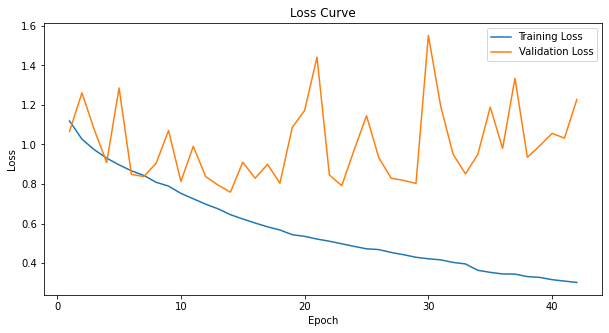

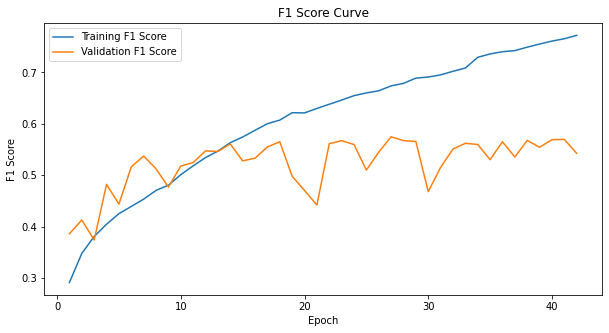

In [259]:
num_epochs = 100  # 设置训练的轮数
best_model_wts = model_a.state_dict()
best_f1_avg = 0.0  # 使用所有类别 F1 分数的平均值作为性能指标
patience = 15
early_stop_counter = 0

train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

scaler = GradScaler()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # 训练阶段
    train_loss, train_f1 = train(model_a, train_loader, criterion_a, optimizer_a)
    train_losses.append(train_loss)
    train_f1_scores.append(train_f1)

    # 打印训练阶段的损失和 F1 分数
    print(f'Train Loss: {train_loss:.4f}, F1 Score: {train_f1:.4f}')
    
    # 验证阶段
    val_loss, best_thresholds, val_f1_scores_per_class, _ = validate(model_a, val_loader, criterion_a)
    val_losses.append(val_loss)
    val_f1_scores.append(np.mean(val_f1_scores_per_class))  # 记录所有类别 F1 分数的平均值

    # 更新学习率调度器
    scheduler_a.step(np.mean(val_f1_scores_per_class))

    # 检查模型是否有改进
    current_avg_f1 = np.mean(val_f1_scores_per_class)
    #benchmark = current_avg_f1 * (1 - val_loss)
    print(f"current avg f1:{current_avg_f1: .4f}")
    if current_avg_f1 > best_f1_avg:
        best_f1_avg = current_avg_f1
        best_model_wts = model_a.state_dict()
        torch.save(model_a.state_dict(), 'best_model.pth')
        print('Best model saved.')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f'No improvement for {early_stop_counter} epoch(s).')

    if early_stop_counter >= patience:
        print('Early stopping triggered.')
        break
    
print('Training complete')

# 绘制损失和 F1 分数的图
import matplotlib.pyplot as plt

actual_epochs = len(train_losses)
plt.figure(figsize=(10, 5))
plt.plot(range(1, actual_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, actual_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, actual_epochs+1), train_f1_scores, label='Training F1 Score')
plt.plot(range(1, actual_epochs+1), val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.show()

In [261]:

from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import f1_score

def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs).detach().cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    preds_binary = (all_preds > 0.7).astype(int)  # 调整阈值
    epoch_f1 = f1_score(all_labels, preds_binary, average='macro')

    return epoch_loss, epoch_f1

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    validate_loader_tqdm = tqdm(dataloader, desc="Validating", leave=False)
    with torch.no_grad():
        for inputs, labels in validate_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # 获取每个类别的最佳阈值和计算每个类别的F1分数
    best_thresholds = find_best_thresholds(all_labels, all_preds)
    best_f1_scores = []

    for i in range(all_labels.shape[1]):  # 遍历每个类别
        threshold = best_thresholds[i]
        preds_binary = (all_preds[:, i] > threshold).astype(int)
        f1 = f1_score(all_labels[:, i], preds_binary)
        best_f1_scores.append(f1)

    # 打印每个类别的最佳阈值和 F1 分数
    for i in range(len(best_f1_scores)):
        print(f'Class {i}: Best Threshold: {best_thresholds[i]:.2f}, F1 Score: {best_f1_scores[i]:.4f}')

    print(f'Validation Loss: {epoch_loss:.4f}')

    # 返回整体验证损失和每类的F1分数
    return epoch_loss, best_f1_scores


In [265]:
print(val_f1_scores_per_class)

[0.5149253731343284, 0.5665859564164648, 0.6244604316546761, 0.6105006105006106, 0.5423728813559322, 0.48251748251748255, 0.3544303797468354, 0.4829821717990275, 0.70373312152502]


In [266]:
class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        # 搜索所有 .png 文件
        self.image_paths = glob.glob(os.path.join(image_dir, '**', '*.png'), recursive=True)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, image_path  # 返回图像和文件路径


In [267]:
def format_id(file_name):
    # 假设 file_name 格式是 "202001010000_RAD_COMP.png"
    # 我们需要的 ID 是 "202001010000"
    base_name = os.path.basename(file_name)  # 从路径中获取基础文件名
    id_part = base_name.split('_')[0]  # 分割并获取日期时间部分
    return id_part

def generate_submission(model, dataloader, output_csv_path, thresholds):
    model.eval()
    predictions = []
    ids = []

    with torch.no_grad():
        for inputs, paths in tqdm(dataloader, desc="Generating Submission"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs).cpu().numpy()  # 将输出从 logits 转为概率
            
            # 按类别应用不同的阈值
            preds = np.zeros_like(outputs)
            for i, thresh in enumerate(thresholds):
                preds[:, i] = (outputs[:, i] >= thresh).astype(float)
            
            predictions.append(preds)
            ids.extend([format_id(path) for path in paths])  # 使用 format_id 获取 ID

    predictions = np.vstack(predictions)
    submission = pd.DataFrame(predictions, columns=[f"label{i}" for i in range(len(thresholds))])
    submission.insert(0, "ID", ids)
    submission.to_csv(output_csv_path, index=False)
    print(f"Submission saved to {output_csv_path}!")


In [268]:
validation_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0234, 0.0241, 0.0240], std=[0.0071, 0.0062, 0.0066])
])

image_dir = './dataset/test_dataset/image'
test_dataset = TestDataset(image_dir, transform=validation_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0,pin_memory=True)

In [269]:
# 确保模型是加载最佳权重
model_a.load_state_dict(torch.load('单模型多头_全部数据_两次训练/best_model.pth'))

# 生成提交文件
generate_submission(model_a, test_loader, "submission_total.csv", thresholds=best_thresholds)

Generating Submission: 100%|██████████| 137/137 [00:25<00:00,  5.40it/s]

Submission saved to submission_total.csv!
